In [1]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

# Just $\langle\tau^n\rangle$ with temperature
now doing pt as well

In [18]:


def loadin(beta,dopdf=False, dodd=False):
    Nmax = None
    data_path = "KTN_data/LJ38/4k"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0))
    BF = beta*u-s
    BF -= BF.min()
    
    
    
    AS,BS = kio.load_AB(data_path,index_sel)
    
    rm_reg = np.zeros(N,bool)
    rm_reg[~(AS+BS)] = BF[~(AS+BS)]>np.percentile(BF[~(AS+BS)],10.0)
    
    r_BF = BF[~rm_reg]
    
    print(rm_reg.sum(),(~(AS+BS)).sum())
    
    #rm_reg = ~(AS+BS)
    
    
    if dopdf:
        # taur p pgt
        pt = np.zeros((2*(3+int(dodd)),400))
    
    if dodd:
        gtDDtau=np.zeros(4)
    
    D = np.ravel(K.sum(axis=0))
    
    rho = np.exp(-BF) * AS
    rho /= rho.sum()
    tau = np.zeros(4)
    Q = (diags(D)-K)[~BS,:][:,~BS]
    x = spsolve(Q,rho[~BS])
    y = spsolve(Q,x)
    tau[0] = x.sum()
    tau[1] = 2.0*y.sum()
    if dopdf:
        pt[0] = np.logspace(-6,3,pt.shape[1])*tau[0]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~BS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
    
    
    
    
    rho = np.exp(-BF) * BS
    rho /= rho.sum()
    
    Q = (diags(D)-K)[~AS,:][:,~AS]
    x = spsolve(Q,rho[~AS])
    y = spsolve(Q,x)
    tau[2] = x.sum()
    tau[3] = 2.0*y.sum()
    
    if dopdf:
        pt[3+int(dodd)] = np.logspace(-6,3,pt.shape[1])*tau[2]
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~AS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[4+int(dodd)] = (v*w*nu)@np.exp(-np.outer(nu,pt[3]))*(v*w/nu).sum()
        
    
    
    # standard GT
    gttau = np.zeros(4)
    rho = (np.exp(-BF) * AS)[~rm_reg] / (np.exp(-BF) * AS).sum()
    GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]
    RBS = BS[~rm_reg]
    Q = GT_Q[:,~RBS][~RBS,:]
    x = spsolve(Q,rho[~RBS])
    y = spsolve(Q,x)
    gttau[0] = x.sum()
    gttau[1] = 2.0*y.sum()
    
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RBS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[2] = (v*w*nu)@np.exp(-np.outer(nu,pt[0])) * (v*w/nu).sum()
    
    
    rho = (np.exp(-BF) * BS)[~rm_reg] / (np.exp(-BF) * BS).sum()
    RAS = AS[~rm_reg]
    
    Q = GT_Q[:,~RAS][~RAS,:]
    x = spsolve(Q,rho[~RAS])
    y = spsolve(Q,x)
    gttau[2] = x.sum()
    gttau[3] = 2.0*y.sum()
    if dopdf:
        nu,v,w = spla.eig(Q.todense(),left=True)
        dp = np.sqrt(np.diagonal(w.T.dot(v))).real
        v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~RAS])
        w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
        nu = nu.real
        pt[5+int(dodd)] = (v*w*nu)@np.exp(-np.outer(nu,pt[3])) * (v*w/nu).sum()
    
    
    # modified GT
    if dodd:
        gtDDtau = np.zeros(4)
        rB,rDD,iGTG,rN,succ = gt.gt_seq(N=N,rm_reg=rm_reg,B=B.copy(),DD=csr_matrix(diags(1.0/D.copy())),trmb=10,retK=True,Ndense=50,screen=False)
        
        GT_Q = gt.gt_seq(N=N,rm_reg=rm_reg,B=B,D=D,trmb=10,retK=True,Ndense=50,screen=False)[2]
        
        rho = (np.exp(-BF) * AS)[~rm_reg] / (np.exp(-BF) * AS).sum()
        RBS = BS[~rm_reg]
        
        iG = iGTG[:,~RBS][~RBS,:]
        Q = GT_Q[:,~RBS][~RBS,:]
        iD = rDD[:,~RBS][~RBS,:]
        x = spsolve(iG,rho[~RBS])
        z = spsolve(Q,rho[~RBS])
        y = spsolve(iG,iD@x)
        print((iD@x).sum(),z.sum())
        gtDDtau[0] = (iD@x).sum()
        gtDDtau[1] = 2.0*(iD@y).sum()
        
        
        if dopdf:
            Q = spsolve(iG[:,~BS[~rm_reg]][~BS[~rm_reg]],rDD[:,~BS[~rm_reg]][~BS[~rm_reg],:])
            nu,v,w = spla.eig(Q.todense(),left=True)
            dp = np.sqrt(np.diagonal(w.T.dot(v))).real
            v = (v.real.dot(np.diag(1.0/dp))).T.dot(rho[~AS[~rm_reg]])
            w = (w.real.dot(np.diag(1.0/dp))).sum(axis=0)
            nu = nu.real
            pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[3]))*(v*w/nu).sum()

    if dopdf:
        if dodd:
            return beta,tau,gttau,gtDDtau,pt
        else:
            return beta,tau,gttau,pt
    else:
        if dodd:
            return beta,tau,gttau,gtDDtau
        else:
            return beta,tau,gttau

In [22]:
data = np.zeros((20,9))
for i,_beta in enumerate(np.linspace(2.5,8.5,20)):
    
    data[i][0],data[i][1:5],data[i][5:9] = loadin(_beta)
    print(data[i][5]/data[i][1])

N,N_TS: 4000 2653
77 767
1.0000000000000024
N,N_TS: 4000 2653
77 767
0.9999999999999977
N,N_TS: 4000 2653
77 767
1.0000000000000016
N,N_TS: 4000 2653
77 767
0.9999999999999991
N,N_TS: 4000 2653
77 767
0.9999999999999991
N,N_TS: 4000 2653
77 767
0.999999999999997
N,N_TS: 4000 2653
77 767
0.9999999999999977
N,N_TS: 4000 2653
77 767
1.0000000000000075
N,N_TS: 4000 2653
77 767
0.9999999999999957
N,N_TS: 4000 2653
77 767
1.0000000000000036
N,N_TS: 4000 2653
77 767
0.9999999999999863
N,N_TS: 4000 2653
77 767
1.0000000000000122
N,N_TS: 4000 2653
77 767
1.0000000000000202
N,N_TS: 4000 2653
77 767
1.000000000000046
N,N_TS: 4000 2653
77 767
1.0000000000001088
N,N_TS: 4000 2653
77 767
1.0000000000001903
N,N_TS: 4000 2653
77 767
1.000000000000198
N,N_TS: 4000 2653
77 767
1.0000000000002156
N,N_TS: 4000 2653
77 767
0.9999999999994571
N,N_TS: 4000 2653
77 767
1.0000000000005345


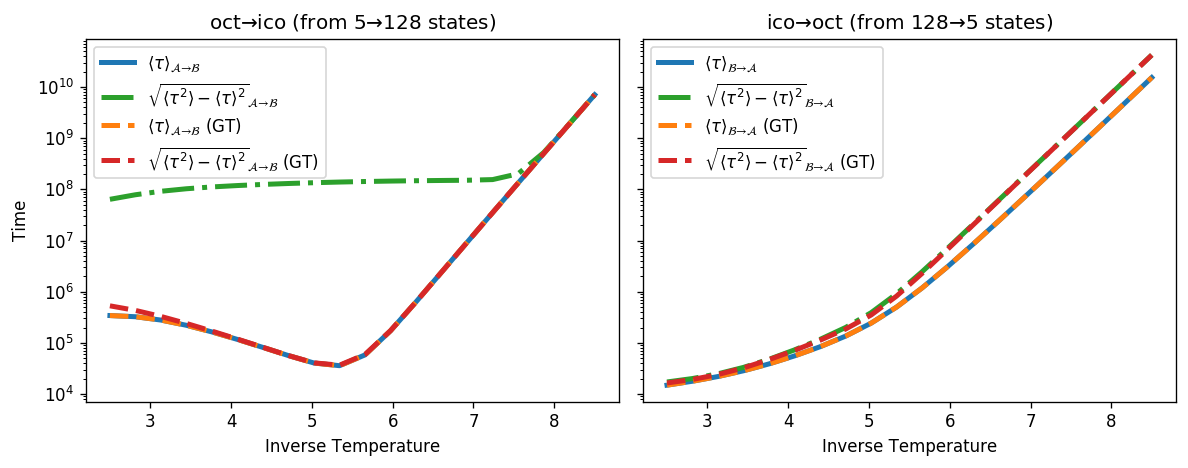

In [23]:

fig,ax = plt.subplots(1,2,figsize=(10,4),dpi=120,sharey=True)



for j in range(2):
    
    names=['oct','ico']
    size=[5,128]
    ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],size[j],size[1-j]))
    names=['A','B']
    ax[j].plot(data[:,0],data[:,1+2*j],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
    ax[j].plot(data[:,0],np.sqrt(data[:,2+2*j]-data[:,1+2*j]**2),'C2-.',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
    
    ax[j].plot(data[:,0],data[:,5+2*j],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
    ax[j].plot(data[:,0],np.sqrt(data[:,6+2*j]-data[:,5+2*j]**2),'C3--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))

    #ax[j].plot(data[:,0],data[:,9+2*j],'C4--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    #ax[j].plot(data[:,0],np.sqrt(data[:,10+2*j]-data[:,9+2*j]**2),'C5--',lw=3,label=r"$\sqrt{\langle\tau^2\rangle-\langle\tau\rangle^2}_\mathcal{%s\to{%s}}$ (VGT)" % (names[j],names[1-j]))
    ax[j].set_xlabel("Inverse Temperature")
    if j==0:
        ax[j].set_ylabel("Time")
    ax[j].legend()
    ax[j].set_yscale("log")
plt.tight_layout()
plt.savefig("GT_retain_r10.pdf")

In [19]:
_beta = 1.0/0.25
beta,tau,gttau,npt = loadin(_beta,dopdf=True)

print(ngttau/ntau)

N,N_TS: 4000 2653
690 767
[1.         1.         1.         0.99690076]


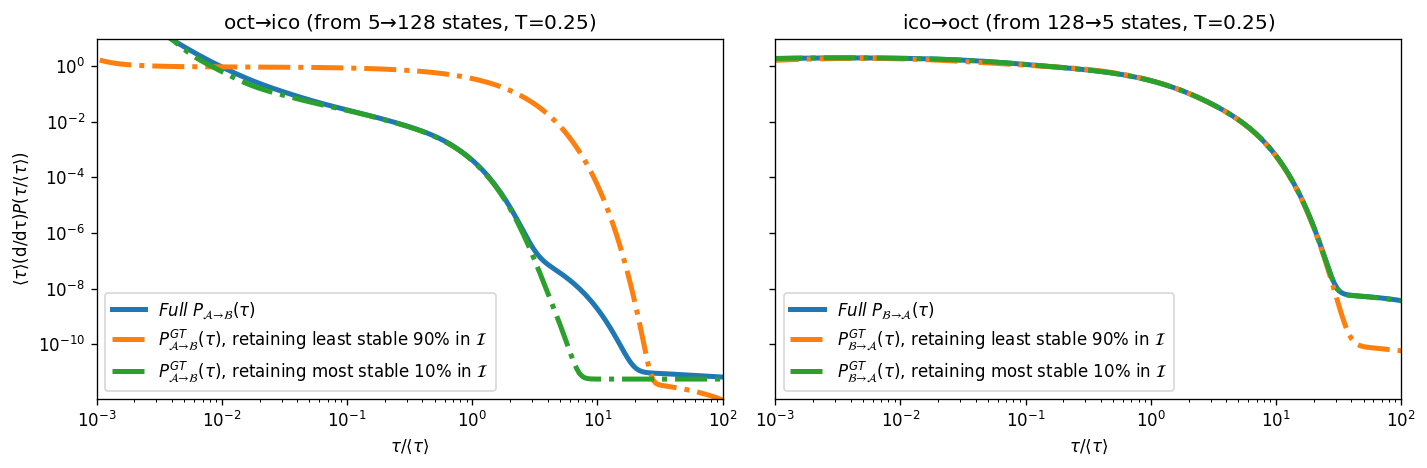

In [27]:

size=[5,128]

fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=120,sharey='row')#,sharex='col')
for j in range(2):
    names=['oct','ico']
    ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states, T=%2.2g)" % (names[j],names[1-j],size[j],size[1-j],1.0/_beta))
    names=["A","B"]

    ax[j].plot(pt[3*j]/tau[2*j],pt[1+3*j],'C0-',lw=3,label=r"$Full$ $P_\mathcal{%s\to{%s}}(\tau)$" % (names[j],names[1-j]))
    ax[j].plot(pt[3*j]/tau[2*j],pt[2+3*j],'C1-.',lw=3,label=r"$P^{GT}_\mathcal{%s\to{%s}}(\tau)$, retaining least stable 90%% in $\mathcal{I}$" % (names[j],names[1-j]))
    ax[j].plot(pt[3*j]/tau[2*j],npt[2+3*j],'C2-.',lw=3,label=r"$ P^{GT}_\mathcal{%s\to{%s}}(\tau)$, retaining most stable 10%% in $\mathcal{I}$" % (names[j],names[1-j]))
    
    ax[j].legend()
    ax[j].set_yscale("log")
    ax[j].set_xscale("log")
    ax[j].set_xlim(0.001,100.)
    ax[j].set_xlabel(r"$\tau/\langle\tau\rangle$")
    if j==0:
        ax[j].set_ylabel(r"$\langle\tau\rangle({\rm d}/{\rm d\tau}){P}(\tau/\langle\tau\rangle)$")
    ax[j].set_ylim(pt[1+3*j].min()/10.0,10.0)
plt.tight_layout()
plt.savefig("GT_WT_025.pdf")

In [ ]:
N = 50
beta = 5.0
pi = np.exp(-beta*np.random.uniform(size=N)-beta*2.0)
pi[N//2] = 1.0

Q = np.exp(-beta*(1.5+15.0*np.random.uniform(size=(N,N))))
Q = np.diag(np.sqrt(pi))@(Q+Q.T)@np.diag(1.0/np.sqrt(pi))
D = np.diag(Q.sum(axis=0))
#M -= np.diag(M.sum(axis=0))

As = np.arange(N)==N-1
Bs = np.arange(N)==0

rho = pi.copy() * Bs.copy()
rho /= rho.sum()


x = spla.solve((D-Q)[:,~As][~As,:],rho[~As])
y = spla.solve((D-Q)[:,~As][~As,:],x)

ptau = [x.sum(),y.sum()]

taus = np.zeros((N-4,2))

rr = np.zeros(N,bool)#np.arange(N)==rms
Dv = Q.sum(axis=0)

for rms in np.arange(N)[2:-2]:
    rr = np.arange(N)==rms
    rr += np.arange(N)==(rms-1)
    rr += np.arange(N)==(rms+1)
    
    GT_Q = gt.gt_seq(N=N,rm_reg=rr,B=csr_matrix(Q@np.diag(1.0/Dv)),D=Dv,trmb=1,retK=True,Ndense=50,screen=False)[2]
    x = spla.solve((GT_Q)[:,~As[~rr]][~As[~rr],:].todense(),rho[~rr][~As[~rr]])
    y = spla.solve((GT_Q)[:,~As[~rr]][~As[~rr],:].todense(),x)
    taus[rms-2][0] = x.sum()/ptau[0]
    taus[rms-2][1] = y.sum()/ptau[1]

plt.figure(figsize=(8,6))
plt.plot(taus[:,0],'o-')
plt.plot(taus[:,1],'o-')
